<a href="https://colab.research.google.com/github/alisonmitchell/Biomedical-Knowledge-Graph/blob/main/05_Relation_Extraction/Groq_Llama3.ipynb"
   target="_parent">
   <img src="https://colab.research.google.com/assets/colab-badge.svg"
      alt="Open in Colab">
</a>

# Groq and Llama3-70b

## 1. Introduction


Inference, in the context of LLMs, is the process of generating reponses to the user's query or prompts in the form of new data or predictions based on the model's learned patterns.

[Groq](https://console.groq.com/playground)'s fast AI inference API for the supported Llama3-70b base model with few-shot prompting to extract triples will demonstrate the generalisation capabilities of LLMs over domain and task-specific NLP models. LLMs can be utilised for a range of NLP tasks, such as Relation Extraction, due to their ability to understand and analyse natural language.

We will provide the annotated text from the KAZU BioNER and Linking step as input, and few-shot prompt the LLM to extract predefined SemRep relations and return a list of subject-predicate-object triples.



## 2. Install/import libraries

In [ ]:
!pip install transformers thefuzz pyvis

In [ ]:
!pip install -q groq

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
import json
import math
import time
import re
import ast
import IPython
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
from groq import Groq
from thefuzz import process
from collections import Counter
from IPython.display import display, HTML
from pyvis.network import Network

## 3. Groq



In [ ]:
with open("api_keys.json") as f:
    data = json.load(f)

In [ ]:
# load Groq API key
groq_api_key = data['keys']["GROQ_API_KEY"]

In [ ]:
# initialise Groq client
client = Groq(api_key=groq_api_key)

### 3.1 System message

The system message defines the context and behaviour for the model with step-by-step instructions as a few-shot prompt with examples of input and expected output. Predefined KAZU entity types and SemRep relations are provided in the prompt.

In [ ]:
system_message = """
You are a biomedical text annotator. Your task is to extract biomedical entities and their relationships from the given text, ensuring precision and clarity. Please follow these guidelines carefully:

- Identify and Annotate Entities: Detect as many relations among entities as possible, including inferred relations based on the sentence structure and context. Only consider entities that are explicitly delineated by parentheses along with their entity type in the format: (disease: SARS-CoV-2).

- Synonyms and Closest Matches: If the exact text does not match the predefined relations list, find the closest synonym. For instance, if the text includes "CURES," which is not in the list, use "TREATS" instead.

- Format: Output a list of triples in the format: [[HEAD ENTITY, HEAD ENTITY TYPE, RELATION, TAIL ENTITY, TAIL ENTITY TYPE], …]. Ensure that the entities are presented as [head entity, head entity type, relation, tail entity, tail entity type], even if they are not in that order in the sentence.

- Avoid Extra Text: Do not return any explanation or additional text, only the triples, NOT "Here is the output:".

- Avoid Duplicate Triples: Do not return exact duplicate triples even if there are duplicates in the text.

Entity Types and Relation Types:

The entity types are: ["disease", "drug", "gene", "measurement", "cell_type", "species", "anatomy", "go_cc", "go_mf", "go_bp", "cell_line", "covid lineage"]

The relation types are: ["ADMINISTERED_TO", "AFFECTS", "ASSOCIATED_WITH", "AUGMENTS", "CAUSES", "COEXISTS_WITH", "COMPARED_WITH", "COMPLICATES", "CONVERTS_TO", "DIAGNOSES", "DISRUPTS", "HIGHER_THAN", "INHIBITS", "INTERACTS_WITH", "ISA", "LOCATION_OF", "LOWER_THAN", "MANIFESTATION_OF", "MEASURES", "METHOD_OF", "OCCURS_IN", "PART_OF", "PRECEDES", "PREDISPOSES", "PREVENTS", "PROCESS_OF", "PRODUCES", "SAME_AS", "STIMULATES", "TREATS", "USES"].

Example 1:

###input: (drug: Baricitinib) was selected as a potential repurposed drug against (disease: SARS-CoV-2) through an artificial intelligence algorithm.

###output: ["Baricitinib", "drug", "TREATS", "SARS-CoV-2", "disease"]

Example 2:

###input We used (drug: hemofiltration) to treat a (species: patient) with (drug: digoxin) overdose that was complicated by refractory (disease: hyperkalemia).

###output: [["hemofiltration", "drug", "TREATS", "patient", "species"],["digoxin overdose", "drug", "PROCESS_OF", "patient", "species"],["hyperkalemia", "disease", "COMPLICATES", "digoxin overdose", "drug"],["hemofiltration", "drug", "TREATS", "digoxin overdose", "drug"]]

Important Notes:

- Only include entities that are explicitly marked with parentheses and their entity type in the text.
- Ensure entities are correctly identified and classified, keeping head entities and tail entities in the right order.
- Capture and infer relations as comprehensively as possible, using only the relation types provided.
- Adhere to the predefined relation types closely, choosing the nearest valid option if no exact match is found.
- Only include biomedical entities and their relationships; ignore any non-biomedical entities.
- Do not add any explanation and text, return only the triples, NOT "Here is the output:".
- If no relation exists, then just answer with an empty list []
"""

### 3.2 User message

We will create a list of test sentences with named entities and entity types contained within parentheses delimiters, for example `(disease: Covid-19)`. This will provide the user message for the assistant to respond to.



In [ ]:
texts = [
    "(drug: Molnupiravir) is a repurposed (disease: Covid-19) (drug: medicine) that was specifically developed to cure (disease: influenza) and is used to treat mild to moderately ill (disease: Covid-19) (species: patients) with high risk of becoming seriously ill.",
    "This article introduces a potential repositioning of the existing drug (drug: etoricoxib), which may inhibit (disease: cytokine storm) to treat (disease: COVID-19) through reducing the activity of (gene: Cyclooxygenase-2) in the conversion of (drug: arachidonic acid) to (drug: prostaglandin).",
    "Likewise, another study showed that repurposed drugs such as (drug: pralatrexate), (drug: carumonam), (drug: aclerasteride), and (drug: granotapide) interacted with (gene: spike protein) of (disease: SARS-CoV-2) and acted as potential binders.",
    "In the context of the pandemic in that year, there was a surge in research on the subject, with (disease: COVID-19)/(disease: SARS-CoV-2)/(disease: Coronavirus) topping the list of keywords as soon as (disease: COVID-19)/(disease: SARS-CoV-2)/(disease: Coronavirus) appeared that year."
]

### 3.3 Compare models

We will compare the relation extraction output for four [supported models](https://console.groq.com/docs/models) - `llama3-70b-8192`, `llama3-8b-8192`, `mixtral-8x7b-32768`, `gemma-7b-it`, and respective token usage.

In [ ]:
models = ['llama3-70b-8192', 'llama3-8b-8192', 'mixtral-8x7b-32768', 'gemma-7b-it']

results = []

def extract_relations(system_message, texts):

    for text in texts:
        row = [text]
        for model in models:

            chat_completion = client.chat.completions.create(
                messages=[
                    {'role': 'system', 'content': system_message},
                    {'role': 'user', 'content': text}
                ],
                model=model,
                temperature=0,
                max_tokens=1024,
                top_p=1,
                stop=None,
                stream=False,
                seed=42
            )
            answer = chat_completion.choices[0].message.content
            row.append(answer)

            # Extract and print token usage information
            api_usage = chat_completion.usage
            print(f"Model: {model}")
            print(
                f"Completion tokens: {api_usage.completion_tokens}",
                f"Prompt tokens: {api_usage.prompt_tokens}",
                f"Total tokens: {api_usage.total_tokens}", sep='\n'
            )
            print("")

        results.append(row)

    return results

In [ ]:
results = extract_relations(system_message, texts)

Model: llama3-70b-8192
Completion tokens: 94
Prompt tokens: 905
Total tokens: 999

Model: llama3-8b-8192
Completion tokens: 76
Prompt tokens: 905
Total tokens: 981

Model: mixtral-8x7b-32768
Completion tokens: 118
Prompt tokens: 1089
Total tokens: 1207

Model: gemma-7b-it
Completion tokens: 87
Prompt tokens: 900
Total tokens: 987

Model: llama3-70b-8192
Completion tokens: 129
Prompt tokens: 915
Total tokens: 1044

Model: llama3-8b-8192
Completion tokens: 131
Prompt tokens: 915
Total tokens: 1046

Model: mixtral-8x7b-32768
Completion tokens: 186
Prompt tokens: 1099
Total tokens: 1285

Model: gemma-7b-it
Completion tokens: 95
Prompt tokens: 905
Total tokens: 1000

Model: llama3-70b-8192
Completion tokens: 197
Prompt tokens: 911
Total tokens: 1108

Model: llama3-8b-8192
Completion tokens: 200
Prompt tokens: 911
Total tokens: 1111

Model: mixtral-8x7b-32768
Completion tokens: 137
Prompt tokens: 1094
Total tokens: 1231

Model: gemma-7b-it
Completion tokens: 88
Prompt tokens: 901
Total token

Prompt tokens are quite high as we have a long system message.

In [ ]:
results

[['(drug: Molnupiravir) is a repurposed (disease: Covid-19) (drug: medicine) that was specifically developed to cure (disease: influenza) and is used to treat mild to moderately ill (disease: Covid-19) (species: patients) with high risk of becoming seriously ill.',
  '[["Molnupiravir", "drug", "TREATS", "Covid-19", "disease"],["Molnupiravir", "drug", "TREATS", "influenza", "disease"],["Molnupiravir", "drug", "TREATS", "patients", "species"],["medicine", "drug", "SAME_AS", "Molnupiravir", "drug"]]',
  '[["Molnupiravir", "drug", "TREATS", "Covid-19", "disease"], ["Molnupiravir", "drug", "TREATS", "patients", "species"], ["Molnupiravir", "drug", "AFFECTS", "influenza", "disease"]]',
  '[["Molnupiravir", "drug", "TREATS", "Covid-19", "disease"], ["Molnupiravir", "drug", "SAME_AS", "medicine", "drug"], ["Molnupiravir", "drug", "TREATS", "influenza", "disease"], ["Molnupiravir", "drug", "TREATS", "species", "species"]]',
  '[["Molnupiravir", "drug", "REPURPOSES", "Covid-19", "disease"], ["Mo

In [ ]:
print(results)

[['(drug: Molnupiravir) is a repurposed (disease: Covid-19) (drug: medicine) that was specifically developed to cure (disease: influenza) and is used to treat mild to moderately ill (disease: Covid-19) (species: patients) with high risk of becoming seriously ill.', '[["Molnupiravir", "drug", "TREATS", "Covid-19", "disease"],["Molnupiravir", "drug", "TREATS", "influenza", "disease"],["Molnupiravir", "drug", "TREATS", "patients", "species"],["medicine", "drug", "SAME_AS", "Molnupiravir", "drug"]]', '[["Molnupiravir", "drug", "TREATS", "Covid-19", "disease"], ["Molnupiravir", "drug", "TREATS", "patients", "species"], ["Molnupiravir", "drug", "AFFECTS", "influenza", "disease"]]', '[["Molnupiravir", "drug", "TREATS", "Covid-19", "disease"], ["Molnupiravir", "drug", "SAME_AS", "medicine", "drug"], ["Molnupiravir", "drug", "TREATS", "influenza", "disease"], ["Molnupiravir", "drug", "TREATS", "species", "species"]]', '[["Molnupiravir", "drug", "REPURPOSES", "Covid-19", "disease"], ["Molnupirav

In [ ]:
with open('2024-06-23_groq_test_few_shot.pickle', "wb") as f:
    pickle.dump(results, f)

The Llama3-70b model performs best as it is the largest model.

In [ ]:
# convert output into a DataFrame
columns = ['Text'] + models
test_results_df = pd.DataFrame(results, columns=columns)

test_results_df

,Text,llama3-70b-8192,llama3-8b-8192,mixtral-8x7b-32768,gemma-7b-it
0,(drug: Molnupiravir) is a repurposed (disease:...,"[[""Molnupiravir"", ""drug"", ""TREATS"", ""Covid-19""...","[[""Molnupiravir"", ""drug"", ""TREATS"", ""Covid-19""...","[[""Molnupiravir"", ""drug"", ""TREATS"", ""Covid-19""...","[[""Molnupiravir"", ""drug"", ""REPURPOSES"", ""Covid..."
1,This article introduces a potential reposition...,"[[""etoricoxib"", ""drug"", ""TREATS"", ""COVID-19"", ...","[[""etoricoxib"", ""drug"", ""TREATS"", ""COVID-19"", ...","[[""etoricoxib"", ""drug"", ""TREATS"", ""COVID-19"", ...","[[""etoricoxib"", ""drug"", ""INHIBITS"", ""cytokine ..."
2,"Likewise, another study showed that repurposed...","[[""pralatrexate"", ""drug"", ""INTERACTS_WITH"", ""s...","[[""pralatrexate"", ""drug"", ""INTERACTS_WITH"", ""s...","[[""pralatrexate"", ""drug"", ""INTERACTS_WITH"", ""s...","[[""pralatrexate"", ""drug"", ""INTERACTS_WITH"", ""s..."
3,"In the context of the pandemic in that year, t...","[[""COVID-19"", ""disease"", ""SAME_AS"", ""SARS-CoV-...","[""COVID-19"", ""disease"", ""AFFECTS"", ""SARS-CoV-2...","[[""COVID-19"", ""disease"", ""SAME_AS"", ""SARS-CoV-...","[[""COVID-19"", ""disease"", ""TOPS"", ""keywords"", ""..."


In [ ]:
with open('2024-06-23_groq_test_few_shot_df.pickle', "wb") as f:
    pickle.dump(test_results_df, f)

## 4. Llama3-70b

We will use [Meta's Llama3-70b](https://huggingface.co/meta-llama/Meta-Llama-3-70B) model via Hugging Face `transformers` library.




In [ ]:
from huggingface_hub import notebook_login

# This will prompt you to enter your token
notebook_login()

Firstly, we will tokenise the entities so we can plot the distribution of token counts per sentence.

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-70B")

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

We will load data from 10 articles for 1224 sentences containing at least one entity identified during the NER and Linking step.

In [ ]:
# load data for unique sentences with one or more entity
full_data =  pd.read_csv('2024-06-10_text_ner_labels_1224_edited.csv')
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224 entries, 0 to 1223
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            1224 non-null   object
 1   text_ner        1224 non-null   object
 2   text_ner_label  1224 non-null   object
 3   idx             1224 non-null   object
 4   article_id      1224 non-null   object
dtypes: object(5)
memory usage: 47.9+ KB


In [ ]:
full_data_tokens = full_data.copy()

### 4.1 Plot token counts

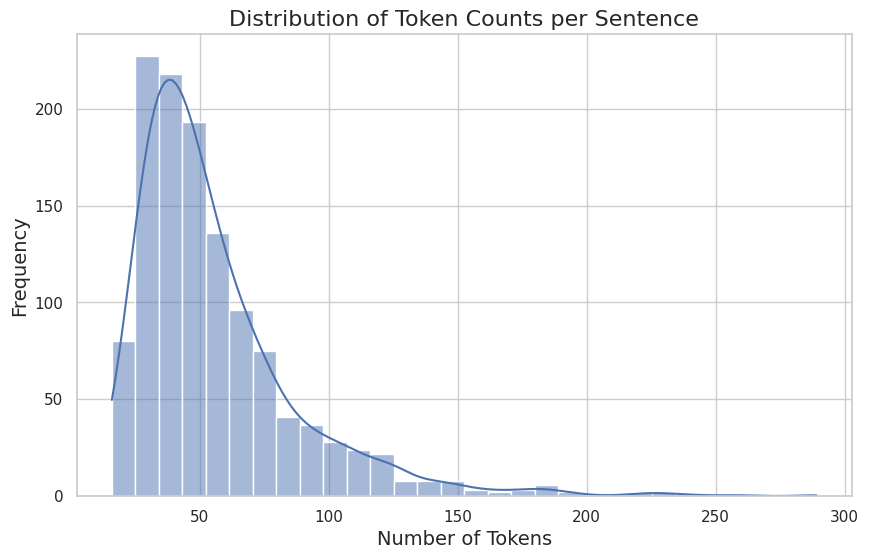

In [ ]:
# Tokenise the text and save the number of tokens to a new column
full_data_tokens['n_tokens'] = full_data_tokens['text_ner_label'].apply(lambda x: len(tokenizer.encode(x)))

# Set the style of the plot
sns.set(style="whitegrid")

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(full_data_tokens['n_tokens'], kde=True, bins=30)

# Add title and labels
plt.title('Distribution of Token Counts per Sentence', fontsize=16)
plt.xlabel('Number of Tokens', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Display the plot
plt.show()

In [ ]:
# Calculate the average number of tokens in a sentence
#average_tokens = unique_rows_df_tokens['n_tokens'].mean()
average_tokens = math.ceil(full_data_tokens['n_tokens'].mean())
max_tokens = full_data_tokens['n_tokens'].max()
min_tokens = full_data_tokens['n_tokens'].min()
print(f'Average number of tokens per sentence: {average_tokens}')
print(f'Maximum number of tokens per sentence: {max_tokens}')
print(f'Minimum number of tokens per sentence: {min_tokens}')

Average number of tokens per sentence: 57
Maximum number of tokens per sentence: 289
Minimum number of tokens per sentence: 16


In [ ]:
# convert column with labelled entities in sentences to list
ner_labels_list = full_data_tokens['text_ner_label'].to_list()

In [ ]:
len(ner_labels_list)

1224

In [ ]:
# display sample of labelled sentences list
ner_labels_list[15:20]

['In the context of the pandemic in that year, there was a surge in research on the subject, with (disease: COVID-19)/(disease: SARS-CoV-2)/(disease: Coronavirus) topping the list of keywords as soon as (disease: COVID-19)/(disease: SARS-CoV-2)/(disease: Coronavirus) appeared that year.',
 'Molecular docking is one of the core steps of virtual screening, and the (disease: COVID-19) pandemic generated many opportunities for the practice of drug repositioning.',
 'Therefore, high-quality studies of the keywords (disease: COVID-19)/(disease: SARS-CoV-2)/(disease: Coronavirus), Virtual screening, and Molecular docking were surveyed, as shown in the bubble chart, in the past two years, reflecting the relevant research trend in recent years.',
 'In a virtual screening process, Gervasoni, S. conducted a literature search for molecular binding sites for (disease: SARS-CoV-2)-associated protein targets while combining pocket and docking searches to propose a new pocket mapping strategy that ide

### 4.2 Optimal batch size

Groq models have [rate limits](https://console.groq.com/settings/limits) for requests and tokens. We will define a function to calculate  the optimal batch size for sentences based on these limits.

In [ ]:
def calculate_batch_size(sentences, tokens_per_sentence, token_limit_per_minute, request_limit_per_minute):
    # Calculate the batch size based on token limits
    batch_size_by_tokens = token_limit_per_minute // tokens_per_sentence

    # Ensure we do not exceed the request limit
    batch_size_by_requests = len(sentences) // request_limit_per_minute

    # The final batch size should respect both limits
    batch_size = min(batch_size_by_tokens, batch_size_by_requests)

    return batch_size


In [ ]:
# Given values
average_tokens_per_sentence = 57
token_limit_per_minute = 6000
request_limit_per_minute = 30


batch_size = calculate_batch_size(ner_labels_list, average_tokens_per_sentence, token_limit_per_minute, request_limit_per_minute)
print(f"Optimal batch size: {batch_size}")

Optimal batch size: 40


## 5. Groq and Llama3-70b

### 5.1 System message

We will use the same system message as for comparing model output for the test sentences.

In [ ]:
system_message = """
You are a biomedical text annotator. Your task is to extract biomedical entities and their relationships from the given text, ensuring precision and clarity. Please follow these guidelines carefully:

- Identify and Annotate Entities: Detect as many relations among entities as possible, including inferred relations based on the sentence structure and context. Only consider entities that are explicitly delineated by parentheses along with their entity type in the format: (disease: SARS-CoV-2).

- Synonyms and Closest Matches: If the exact text does not match the predefined relations list, find the closest synonym. For instance, if the text includes "CURES," which is not in the list, use "TREATS" instead.

- Format: Output a list of triples in the format: [[HEAD ENTITY, HEAD ENTITY TYPE, RELATION, TAIL ENTITY, TAIL ENTITY TYPE], …]. Ensure that the entities are presented as [head entity, head entity type, relation, tail entity, tail entity type], even if they are not in that order in the sentence.

- Avoid Extra Text: Do not return any explanation or additional text, only the triples, NOT "Here is the output:".

- Avoid Duplicate Triples: Do not return exact duplicate triples even if there are duplicates in the text.

Entity Types and Relation Types:

The entity types are: ["disease", "drug", "gene", "measurement", "cell_type", "species", "anatomy", "go_cc", "go_mf", "go_bp", "cell_line", "covid lineage"]

The relation types are: ["ADMINISTERED_TO", "AFFECTS", "ASSOCIATED_WITH", "AUGMENTS", "CAUSES", "COEXISTS_WITH", "COMPARED_WITH", "COMPLICATES", "CONVERTS_TO", "DIAGNOSES", "DISRUPTS", "HIGHER_THAN", "INHIBITS", "INTERACTS_WITH", "ISA", "LOCATION_OF", "LOWER_THAN", "MANIFESTATION_OF", "MEASURES", "METHOD_OF", "OCCURS_IN", "PART_OF", "PRECEDES", "PREDISPOSES", "PREVENTS", "PROCESS_OF", "PRODUCES", "SAME_AS", "STIMULATES", "TREATS", "USES"].

Example 1:

###input: (drug: Baricitinib) was selected as a potential repurposed drug against (disease: SARS-CoV-2) through an artificial intelligence algorithm.

###output: ["Baricitinib", "drug", "TREATS", "SARS-CoV-2", "disease"]

Example 2:

###input We used (drug: hemofiltration) to treat a (species: patient) with (drug: digoxin) overdose that was complicated by refractory (disease: hyperkalemia).

###output: [["hemofiltration", "drug", "TREATS", "patient", "species"],["digoxin overdose", "drug", "PROCESS_OF", "patient", "species"],["hyperkalemia", "disease", "COMPLICATES", "digoxin overdose", "drug"],["hemofiltration", "drug", "TREATS", "digoxin overdose", "drug"]]

Important Notes:

- Only include entities that are explicitly marked with parentheses and their entity type in the text.
- Ensure entities are correctly identified and classified, keeping head entities and tail entities in the right order.
- Capture and infer relations as comprehensively as possible, using only the relation types provided.
- Adhere to the predefined relation types closely, choosing the nearest valid option if no exact match is found.
- Only include biomedical entities and their relationships; ignore any non-biomedical entities.
- Do not add any explanation and text, return only the triples, NOT "Here is the output:".
- If no relation exists, then just answer with an empty list []
"""

### 5.2 Messages list

We will build the messages list for the system and user messages as per the required conversational format for the model, and display sample output for a message.

In [ ]:
messages = [[
    {"role": "system","content": f"{system_message}"},
    {"role": "user", "content": e}] for e in ner_labels_list]
messages[20]

[{'role': 'system',
  'content': '\nYou are a biomedical text annotator. Your task is to extract biomedical entities and their relationships from the given text, ensuring precision and clarity. Please follow these guidelines carefully:\n\n- Identify and Annotate Entities: Detect as many relations among entities as possible, including inferred relations based on the sentence structure and context. Only consider entities that are explicitly delineated by parentheses along with their entity type in the format: (disease: SARS-CoV-2).\n\n- Synonyms and Closest Matches: If the exact text does not match the predefined relations list, find the closest synonym. For instance, if the text includes "CURES," which is not in the list, use "TREATS" instead.\n\n- Format: Output a list of triples in the format: [[HEAD ENTITY, HEAD ENTITY TYPE, RELATION, TAIL ENTITY, TAIL ENTITY TYPE], …]. Ensure that the entities are presented as [head entity, head entity type, relation, tail entity, tail entity type],

### 5.3 Extract triples

We will use Llama3-70b (`llama3-70b-8192` with context window of 8192 tokens) as the model for the Groq Chat Completions API to process the batches of messages and generate output responses.

We will define some helper functions to interact with the chat interface.

In [ ]:
def extract_relations(prompt):

    """Send one request and retrieve model's generation."""

    chat_completion = client.chat.completions.create(
        messages=prompt,
        model='llama3-70b-8192',
        temperature=0,
        max_tokens=1024,
        top_p=1,
        stop=None,
        stream=False,
        seed=42
    )
    return chat_completion.choices[0].message.content

In [ ]:
def send_messages(messages):
    """Process messages in batches with a pause between batches."""
    results = []
    batch_size = 40
    requests_per_minute_limit = 30

    for i in tqdm(range(0, len(messages), batch_size)):
        batch = messages[i:i + batch_size]  # get the next batch of messages

        for message in batch:
            output = extract_relations(message)
            results.append(output)

        # Calculate the number of batches processed so far
        batches_processed = (i // batch_size) + 1

        # Pause to respect the rate limit of 30 requests per minute
        if batches_processed % requests_per_minute_limit == 0 and i + batch_size < len(messages):
            time.sleep(10)  # wait for 10 seconds

    return results

In [ ]:
# Generate the Data

results = send_messages(messages)
with open('2024-06-17_groq_llama-3-70b_triples.pickle', 'wb') as f:
  pickle.dump(results, f)

100%|██████████| 31/31 [1:35:43<00:00, 185.28s/it]


In [ ]:
len(results)

1224

In [ ]:
results

['["sildenafil", "drug", "TREATS", "male erectile dysfunction", "disease"],["sildenafil", "drug", "TREATS", "pulmonary hypertension", "disease"],["bupropion", "drug", "TREATS", "smoking cessation", "disease"],["thalidomide", "drug", "TREATS", "multiple myeloma", "disease"],["thalidomide", "drug", "TREATS", "chronic graft-versus-host disease", "disease"]',
 '["precision medicine", "measurement", "ISA", "medicine", "measurement"]',
 '["precision medicine", "measurement", "ISA", "medicine", "measurement"]',
 '[["drug repositioning", "drug", "TREATS", "neurological diseases", "disease"], ["drug repositioning", "drug", "TREATS", "cancer", "disease"], ["drug repositioning", "drug", "TREATS", "rare diseases", "disease"], ["drug repositioning", "drug", "TREATS", "infectious diseases", "disease"]]',
 '[["aspirin", "drug", "ISA", "drug", "drug"], ["aspirin", "drug", "STUDIED_IN", "study", "study"]]',
 '["Bibliometrics", "measurement", "MEASURES", "range", "measurement"]',
 '[["date", "measuremen

## 6. Postprocessing

### 6.1 Data cleaning

We will extract valid lists from the model's output and flatten the nested lists to convert to a DataFrame.

In [ ]:
# Preprocess strings to remove unwanted text
def extract_valid_lists(text):
    pattern = re.compile(r'\[\[.*?\]\]|\[.*?\]')
    matches = pattern.findall(text)
    return matches

# Extract and clean up the matches
cleaned_matches = []
for item in results:
    matches = extract_valid_lists(item)
    cleaned_matches.extend(matches)

# Flatten the nested lists
flattened_list = []
for match in cleaned_matches:
    try:
        list_element = ast.literal_eval(match)
        if isinstance(list_element, list):
            if all(isinstance(elem, list) for elem in list_element):
                flattened_list.extend(list_element)
            else:
                flattened_list.append(list_element)
    except (ValueError, SyntaxError):
        continue

# Convert the flattened list into a DataFrame
columns = ['head_entity', 'head_entity_type', 'relation', 'tail_entity', 'tail_entity_type']
triples_df = pd.DataFrame(flattened_list, columns=columns)

In [ ]:
triples_df

,head_entity,head_entity_type,relation,tail_entity,tail_entity_type
0,sildenafil,drug,TREATS,male erectile dysfunction,disease
1,sildenafil,drug,TREATS,pulmonary hypertension,disease
2,bupropion,drug,TREATS,smoking cessation,disease
3,thalidomide,drug,TREATS,multiple myeloma,disease
4,thalidomide,drug,TREATS,chronic graft-versus-host disease,disease
...,...,...,...,...,...
3751,SARS-CoV-2 infected,disease,AFFECTS,alveolar type II cells,cell_type
3752,SARS-CoV-2 infected,disease,AFFECTS,African green monkey kidney cells,cell_type
3753,alveolar type II cells,cell_type,ISA,control group,cell_type
3754,African green monkey kidney cells,cell_type,ISA,control group,cell_type


In [ ]:
with open('2024-06-17_llama3-70b-groq_triples_3756.pickle', "wb") as f:
    pickle.dump(triples_df, f)

### 6.2 Add entity IDs

We will add the `entity_id` data extracted by KAZU during the NER and Linking stage to the Llama3-70b triples data.

In [ ]:
# load KAZU sentences with entities only
with open('2024-05-10_kazu_entities_only_3447.pickle', 'rb') as f:
  kazu_entities_only = pickle.load(f)

In [ ]:
kazu_entities_only

,entity_id,entity_type,entity,span_start,span_end,text,idx,article_id
0,chembl:CHEMBL192,drug,sildenafil,38,48,"Since the 1990s, the repositioning of sildenaf...",22200652f00d4d5fb5875f619734eaed,PMC9549161
1,HP:0100639,disease,male erectile dysfunction,53,78,"Since the 1990s, the repositioning of sildenaf...",22200652f00d4d5fb5875f619734eaed,PMC9549161
2,MONDO:0005149,disease,pulmonary hypertension,83,105,"Since the 1990s, the repositioning of sildenaf...",22200652f00d4d5fb5875f619734eaed,PMC9549161
3,chembl:CHEMBL894,drug,bupropion,144,153,"Since the 1990s, the repositioning of sildenaf...",22200652f00d4d5fb5875f619734eaed,PMC9549161
4,chembl:CHEMBL468,drug,thalidomide,197,208,"Since the 1990s, the repositioning of sildenaf...",22200652f00d4d5fb5875f619734eaed,PMC9549161
...,...,...,...,...,...,...,...,...
3442,STATO:0000569,measurement,score,4,9,The score for each drug is equal to the sum of...,f06e07ee624e49de824cb35e524cef19,PMC9556799
3443,covid,disease,SARS-CoV-2 infected,36,55,We used gene expression profiles of SARS-CoV-2...,a04c0a5ddb544b91a90c308a89e267d9,PMC9556799
3444,CL:0002063,cell_type,alveolar type II cells,89,111,We used gene expression profiles of SARS-CoV-2...,a04c0a5ddb544b91a90c308a89e267d9,PMC9556799
3445,African green monkey kidney cells,cell_type,African green monkey kidney cells,116,149,We used gene expression profiles of SARS-CoV-2...,a04c0a5ddb544b91a90c308a89e267d9,PMC9556799


In [ ]:
kazu_entities_only.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3447 entries, 0 to 3446
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   entity_id    3447 non-null   object
 1   entity_type  3447 non-null   object
 2   entity       3447 non-null   object
 3   span_start   3447 non-null   Int64 
 4   span_end     3447 non-null   Int64 
 5   text         3447 non-null   object
 6   idx          3447 non-null   object
 7   article_id   3447 non-null   object
dtypes: Int64(2), object(6)
memory usage: 222.3+ KB


We will define a function which performs fuzzy matching of Llama3-70b entities against KAZU entities using [`thefuzz`](https://github.com/seatgeek/thefuzz) string matching library.

If a match is found a tuple is returned where the first value is the matched entity and the second value is the score. If it is above a certain threshold it is considered a match and the `entity_id` from the KAZU dataset will be returned, else the original entity name is returned.

In [ ]:
# Function to match entity and get the entity_id
def get_entity_id(entity, entity_type, entities_df):
    match = process.extractOne(entity, entities_df['entity'])
    if match:
        match_entity, score = match[:2]  # Unpack the first two values: matched entity and score
        if score >= 90:
            entity_row = entities_df[(entities_df['entity'] == match_entity) & (entities_df['entity_type'] == entity_type)]
            if not entity_row.empty:
                return entity_row.iloc[0]['entity_id']
    # Return the entity name if no ID is found
    return entity


In [ ]:
# Add columns for head_entity_id and tail_entity_id
triples_df['head_entity_id'] = triples_df.apply(lambda row: get_entity_id(row['head_entity'], row['head_entity_type'], kazu_entities_only), axis=1)
triples_df['tail_entity_id'] = triples_df.apply(lambda row: get_entity_id(row['tail_entity'], row['tail_entity_type'], kazu_entities_only), axis=1)

In [ ]:
triples_df

,head_entity,head_entity_type,relation,tail_entity,tail_entity_type,head_entity_id,tail_entity_id
0,sildenafil,drug,TREATS,male erectile dysfunction,disease,chembl:CHEMBL192,HP:0100639
1,sildenafil,drug,TREATS,pulmonary hypertension,disease,chembl:CHEMBL192,MONDO:0005149
2,bupropion,drug,TREATS,smoking cessation,disease,chembl:CHEMBL894,smoking cessation
3,thalidomide,drug,TREATS,multiple myeloma,disease,chembl:CHEMBL468,MONDO:0009693
4,thalidomide,drug,TREATS,chronic graft-versus-host disease,disease,chembl:CHEMBL468,MONDO:0020547
...,...,...,...,...,...,...,...
3751,SARS-CoV-2 infected,disease,AFFECTS,alveolar type II cells,cell_type,covid,CL:0002063
3752,SARS-CoV-2 infected,disease,AFFECTS,African green monkey kidney cells,cell_type,covid,African green monkey kidney cells
3753,alveolar type II cells,cell_type,ISA,control group,cell_type,CL:0002063,control group
3754,African green monkey kidney cells,cell_type,ISA,control group,cell_type,African green monkey kidney cells,control group


In [ ]:
with open('2024-06-17_llama3-70b-groq_triples_ids_3756.pickle', "wb") as f:
    pickle.dump(triples_df, f)

In [ ]:
triples_df.to_csv('2024-06-17_llama3-70b-groq_triples_ids_3756.csv', index=False)

### 6.3 Entity and Relation counts

In [ ]:
# Filter the DataFrame and get counts
relation_counts = triples_df['relation'].value_counts()
head_entity_type_counts = triples_df['head_entity_type'].value_counts()
tail_entity_type_counts = triples_df['tail_entity_type'].value_counts()

In [ ]:
# Display the counts without truncation
pd.set_option('display.max_rows', None)

In [ ]:
# Print Relation counts
print("Relation Counts:")
print(relation_counts)


Relation Counts:
relation
TREATS                       547
ASSOCIATED_WITH              512
ISA                          416
AFFECTS                      343
INTERACTS_WITH               304
PART_OF                      233
INHIBITS                     166
MEASURES                     143
SAME_AS                       89
PROCESS_OF                    65
LOCATION_OF                   64
BINDS_TO                      61
COMPARES_WITH                 55
USES                          53
AUGMENTS                      51
CAUSES                        49
TARGETS                       41
ADMINISTERED_TO               24
HAS                           20
CONTAINS                      20
METHOD_OF                     19
HAS_MUTATION                  17
OCCURS_IN                     15
SHOWS                         12
PRODUCES                      11
PREVENTS                      11
MANIFESTATION_OF              10
COMPLICATES                    9
DISRUPTS                       9
SHOWS_EFFICACY_IN

There are lot more relation types than in the predefined list specified in the system message.

We will create a list of the predefined relation types and filter for those in the list, and those chosen by the model as the nearest valid option where no exact match was found.

In [ ]:
# Define predefined relation types
predefined_relations = ['ADMINISTERED_TO', 'AFFECTS', 'ASSOCIATED_WITH', 'AUGMENTS', 'CAUSES', 'COEXISTS_WITH',
                        'COMPARED_WITH', 'COMPLICATES', 'CONVERTS_TO', 'DIAGNOSES', 'DISRUPTS', 'HIGHER_THAN',
                        'INHIBITS', 'INTERACTS_WITH', 'ISA', 'LOCATION_OF', 'LOWER_THAN', 'MANIFESTATION_OF',
                        'MEASURES', 'METHOD_OF', 'OCCURS_IN', 'PART_OF', 'PRECEDES', 'PREDISPOSES', 'PREVENTS',
                        'PROCESS_OF', 'PRODUCES', 'SAME_AS', 'STIMULATES', 'TREATS', 'USES']

In [ ]:
# Filter predefined and non-predefined relations
predefined_relation_counts = relation_counts[relation_counts.index.isin(predefined_relations)]
non_predefined_relation_counts = relation_counts[~relation_counts.index.isin(predefined_relations)]

In [ ]:
predefined_relation_counts

relation
TREATS              547
ASSOCIATED_WITH     512
ISA                 416
AFFECTS             343
INTERACTS_WITH      304
PART_OF             233
INHIBITS            166
MEASURES            143
SAME_AS              89
PROCESS_OF           65
LOCATION_OF          64
USES                 53
AUGMENTS             51
CAUSES               49
ADMINISTERED_TO      24
METHOD_OF            19
OCCURS_IN            15
PRODUCES             11
PREVENTS             11
MANIFESTATION_OF     10
COMPLICATES           9
DISRUPTS              9
HIGHER_THAN           7
LOWER_THAN            7
STIMULATES            6
COEXISTS_WITH         3
COMPARED_WITH         3
CONVERTS_TO           3
Name: count, dtype: int64

In [ ]:
non_predefined_relation_counts

relation
BINDS_TO                     61
COMPARES_WITH                55
TARGETS                      41
HAS                          20
CONTAINS                     20
HAS_MUTATION                 17
SHOWS                        12
SHOWS_EFFICACY_IN             9
ACTS_ON                       7
REGISTERED_AS                 7
HAS_PART                      7
SCREENED_AGAINST              6
EVALUATED_AS_TARGET           6
TARGET_OF                     6
USED_FOR                      6
RANKED                        6
RECOMMENDS                    5
IN_VITRO                      5
HAS_COMPONENT                 5
INVOLVED_IN                   5
TARGETED_BY                   5
EXPRESSES_IN                  5
REQUIRES                      5
DISPLAYS                      5
IN_PHASE                      5
HAS_EFFECT                    4
HAS_DOMAIN                    4
FINDS                         4
EXPRESSED_BY                  4
HAS_NO_EFFECT_AGAINST         4
ENABLES                       4

We will do the same for head entity types.

In [ ]:
print("\nHead Entity Type Counts:")
print(head_entity_type_counts)


Head Entity Type Counts:
head_entity_type
drug             1371
disease          1004
gene              783
measurement       369
anatomy            33
species            29
go_bp              27
covid lineage      23
go_mf              22
cell_type          21
go_cc              19
cell_line          15
protein            11
author             11
model               5
mutation            4
software_tool       3
                    2
database            2
complex             1
algorithm           1
Name: count, dtype: int64


There are more than the predefined list of 12 entity types, and one that looks like an empty string.

We will create a list of the predefined entity types and filter for those in the list, and those introduced by the model.

In [ ]:
entity_types = ['disease', 'drug', 'gene', 'measurement', 'cell_type', 'species', 'anatomy', 'go_cc', 'go_mf', 'go_bp', 'cell_line', 'covid lineage']

In [ ]:
# Filter predefined and non-predefined relations
predefined_head_entity_type_counts = head_entity_type_counts[head_entity_type_counts.index.isin(entity_types)]
non_predefined_head_entity_type_counts = head_entity_type_counts[~head_entity_type_counts.index.isin(entity_types)]

In [ ]:
predefined_head_entity_type_counts

head_entity_type
drug             1371
disease          1004
gene              783
measurement       369
anatomy            33
species            29
go_bp              27
covid lineage      23
go_mf              22
cell_type          21
go_cc              19
cell_line          15
Name: count, dtype: int64

In [ ]:
non_predefined_head_entity_type_counts

head_entity_type
protein          11
author           11
model             5
mutation          4
software_tool     3
                  2
database          2
complex           1
algorithm         1
Name: count, dtype: int64

Lastly, we will do the same for tail entity types.

In [ ]:
print("\nTail Entity Type Counts:")
print(tail_entity_type_counts)


Tail Entity Type Counts:
tail_entity_type
disease               1437
gene                   650
measurement            621
drug                   497
species                144
anatomy                127
cell_type               69
go_bp                   42
protein                 37
go_cc                   28
go_mf                   21
process                 15
cell_line               11
database                 9
author                   8
biological process       6
complex                  6
biological_process       5
module                   2
                         2
covid lineage            2
organization             2
literature               1
study                    1
process_of               1
model                    1
entity                   1
research                 1
Name: count, dtype: int64


In [ ]:
# Filter predefined and non-predefined relations
predefined_tail_entity_type_counts = tail_entity_type_counts[tail_entity_type_counts.index.isin(entity_types)]
non_predefined_tail_entity_type_counts = tail_entity_type_counts[~tail_entity_type_counts.index.isin(entity_types)]

In [ ]:
predefined_tail_entity_type_counts

tail_entity_type
disease          1437
gene              650
measurement       621
drug              497
species           144
anatomy           127
cell_type          69
go_bp              42
go_cc              28
go_mf              21
cell_line          11
covid lineage       2
Name: count, dtype: int64

In [ ]:
non_predefined_tail_entity_type_counts

tail_entity_type
protein               37
process               15
database               9
author                 8
biological process     6
complex                6
biological_process     5
module                 2
                       2
organization           2
literature             1
study                  1
process_of             1
model                  1
entity                 1
research               1
Name: count, dtype: int64

#### 6.3.1 Keep predefined relations

We will keep the triples with the predefined relation types.

In [ ]:
triples_predefined_rels_df = triples_df[triples_df['relation'].isin(predefined_relations)]

In [ ]:
len(triples_predefined_rels_df)

3172

In [ ]:
triples_predefined_rels_df

,head_entity,head_entity_type,relation,tail_entity,tail_entity_type,head_entity_id,tail_entity_id
0,sildenafil,drug,TREATS,male erectile dysfunction,disease,chembl:CHEMBL192,HP:0100639
1,sildenafil,drug,TREATS,pulmonary hypertension,disease,chembl:CHEMBL192,MONDO:0005149
2,bupropion,drug,TREATS,smoking cessation,disease,chembl:CHEMBL894,smoking cessation
3,thalidomide,drug,TREATS,multiple myeloma,disease,chembl:CHEMBL468,MONDO:0009693
4,thalidomide,drug,TREATS,chronic graft-versus-host disease,disease,chembl:CHEMBL468,MONDO:0020547
...,...,...,...,...,...,...,...
3751,SARS-CoV-2 infected,disease,AFFECTS,alveolar type II cells,cell_type,covid,CL:0002063
3752,SARS-CoV-2 infected,disease,AFFECTS,African green monkey kidney cells,cell_type,covid,African green monkey kidney cells
3753,alveolar type II cells,cell_type,ISA,control group,cell_type,CL:0002063,control group
3754,African green monkey kidney cells,cell_type,ISA,control group,cell_type,African green monkey kidney cells,control group


In [ ]:
with open('2024-06-17_llama3-70b-groq_triples_predef_rels_3172.pickle', "wb") as f:
    pickle.dump(triples_predefined_rels_df, f)

In [ ]:
triples_predefined_rels_df.to_csv('2024-06-17_llama3-70b-groq_triples_predef_rels_3172.csv', index=False)

#### 6.3.2 Keep predefined entity types

We will keep the triples with the predefined entity types.

In [ ]:
triples_predefined_ent_types_df = triples_predefined_rels_df[triples_predefined_rels_df[['head_entity_type', 'tail_entity_type']].isin(entity_types).all(1)]

In [ ]:
len(triples_predefined_ent_types_df)

3082

In [ ]:
triples_predefined_ent_types_df

,head_entity,head_entity_type,relation,tail_entity,tail_entity_type,head_entity_id,tail_entity_id
0,sildenafil,drug,TREATS,male erectile dysfunction,disease,chembl:CHEMBL192,HP:0100639
1,sildenafil,drug,TREATS,pulmonary hypertension,disease,chembl:CHEMBL192,MONDO:0005149
2,bupropion,drug,TREATS,smoking cessation,disease,chembl:CHEMBL894,smoking cessation
3,thalidomide,drug,TREATS,multiple myeloma,disease,chembl:CHEMBL468,MONDO:0009693
4,thalidomide,drug,TREATS,chronic graft-versus-host disease,disease,chembl:CHEMBL468,MONDO:0020547
...,...,...,...,...,...,...,...
3751,SARS-CoV-2 infected,disease,AFFECTS,alveolar type II cells,cell_type,covid,CL:0002063
3752,SARS-CoV-2 infected,disease,AFFECTS,African green monkey kidney cells,cell_type,covid,African green monkey kidney cells
3753,alveolar type II cells,cell_type,ISA,control group,cell_type,CL:0002063,control group
3754,African green monkey kidney cells,cell_type,ISA,control group,cell_type,African green monkey kidney cells,control group


In [ ]:
triples_predefined_ent_types_df.reset_index(drop=True)
triples_predefined_ent_types_df

,head_entity,head_entity_type,relation,tail_entity,tail_entity_type,head_entity_id,tail_entity_id
0,sildenafil,drug,TREATS,male erectile dysfunction,disease,chembl:CHEMBL192,HP:0100639
1,sildenafil,drug,TREATS,pulmonary hypertension,disease,chembl:CHEMBL192,MONDO:0005149
2,bupropion,drug,TREATS,smoking cessation,disease,chembl:CHEMBL894,smoking cessation
3,thalidomide,drug,TREATS,multiple myeloma,disease,chembl:CHEMBL468,MONDO:0009693
4,thalidomide,drug,TREATS,chronic graft-versus-host disease,disease,chembl:CHEMBL468,MONDO:0020547
...,...,...,...,...,...,...,...
3751,SARS-CoV-2 infected,disease,AFFECTS,alveolar type II cells,cell_type,covid,CL:0002063
3752,SARS-CoV-2 infected,disease,AFFECTS,African green monkey kidney cells,cell_type,covid,African green monkey kidney cells
3753,alveolar type II cells,cell_type,ISA,control group,cell_type,CL:0002063,control group
3754,African green monkey kidney cells,cell_type,ISA,control group,cell_type,African green monkey kidney cells,control group


In [ ]:
with open('2024-06-17_llama3-70b-groq_triples_predef_rels_ent_types_3082.pickle', "wb") as f:
    pickle.dump(triples_predefined_ent_types_df, f)

In [ ]:
triples_predefined_ent_types_df.to_csv('2024-06-17_llama3-70b-groq_triples_predef_rels_ent_types_3082.csv', index=False)

### 6.4 Normalisation



#### 6.4.1 Lowercase entities

We will lowercase the head and tail entities where they are identical because a CUI could not be found. This ensures that CUIs are left in the original format before lowercasing all head and tail entities.

In [ ]:
# make a copy of the DataFrame containing predefined relations and entities
triples_predefined_ent_types_df_lcase = triples_predefined_ent_types_df.copy()

In [ ]:
# Lowercase head_entity and head_entity_id where they are identical
triples_predefined_ent_types_df_lcase['head_entity'] = triples_predefined_ent_types_df_lcase.apply(
    lambda row: row['head_entity'].lower() if row['head_entity'].lower() == row['head_entity_id'].lower() else row['head_entity'], axis=1
)
triples_predefined_ent_types_df_lcase['head_entity_id'] = triples_predefined_ent_types_df_lcase.apply(
    lambda row: row['head_entity_id'].lower() if row['head_entity'].lower() == row['head_entity_id'].lower() else row['head_entity_id'], axis=1
)

# Lowercase tail_entity and tail_entity_id where they are identical
triples_predefined_ent_types_df_lcase['tail_entity'] = triples_predefined_ent_types_df_lcase.apply(
    lambda row: row['tail_entity'].lower() if row['tail_entity'].lower() == row['tail_entity_id'].lower() else row['tail_entity'], axis=1
)
triples_predefined_ent_types_df_lcase['tail_entity_id'] = triples_predefined_ent_types_df_lcase.apply(
    lambda row: row['tail_entity_id'].lower() if row['tail_entity'].lower() == row['tail_entity_id'].lower() else row['tail_entity_id'], axis=1
)

In [ ]:
# Lowercase all head_entity and tail_entity values
triples_predefined_ent_types_df_lcase['head_entity'] = triples_predefined_ent_types_df_lcase['head_entity'].str.lower()
triples_predefined_ent_types_df_lcase['tail_entity'] = triples_predefined_ent_types_df_lcase['tail_entity'].str.lower()

In [ ]:
triples_predefined_ent_types_df_lcase

,head_entity,head_entity_type,relation,tail_entity,tail_entity_type,head_entity_id,tail_entity_id
0,sildenafil,drug,TREATS,male erectile dysfunction,disease,chembl:CHEMBL192,HP:0100639
1,sildenafil,drug,TREATS,pulmonary hypertension,disease,chembl:CHEMBL192,MONDO:0005149
2,bupropion,drug,TREATS,smoking cessation,disease,chembl:CHEMBL894,smoking cessation
3,thalidomide,drug,TREATS,multiple myeloma,disease,chembl:CHEMBL468,MONDO:0009693
4,thalidomide,drug,TREATS,chronic graft-versus-host disease,disease,chembl:CHEMBL468,MONDO:0020547
...,...,...,...,...,...,...,...
3751,sars-cov-2 infected,disease,AFFECTS,alveolar type ii cells,cell_type,covid,CL:0002063
3752,sars-cov-2 infected,disease,AFFECTS,african green monkey kidney cells,cell_type,covid,african green monkey kidney cells
3753,alveolar type ii cells,cell_type,ISA,control group,cell_type,CL:0002063,control group
3754,african green monkey kidney cells,cell_type,ISA,control group,cell_type,african green monkey kidney cells,control group


#### 6.4.2 Replace aliases with canonicals

We will load the JSON file created for REBEL triples and use this to replace synonyms with canonicals for the Llama3-70b entities.


In [ ]:
with open('2024-07-13_merged_llama3_canonicals_updated.json', 'w') as f:
    merged_json_updated = json.load(f)

In [ ]:
# Create a mapping from aliases to canonical entities
def create_alias_to_canonical_mapping(json_output):
    data = json_output
    alias_to_canonical = {}
    for entity in data["entities"]:
        canonical = entity["canonical"]
        aliases = entity["aliases"]
        for alias in aliases:
            alias_to_canonical[alias] = canonical
    return alias_to_canonical

In [ ]:
alias_to_canonical = create_alias_to_canonical_mapping(merged_json_updated)

In [ ]:
alias_to_canonical

{'sars-cov-2 a': 'sars-cov-2',
 'sars-': 'sars-cov-2',
 'sars-cov2': 'sars-cov-2',
 'sars-cov-2 illness': 'sars-cov-2',
 'sarscov2': 'sars-cov-2',
 'sars-cov-2 variant': 'sars-cov-2',
 'sars-cov-2 pathogenicity': 'sars-cov-2',
 'sarscov-2': 'sars-cov-2',
 'sars-cov-2 infection': 'sars-cov-2',
 'sars-cov-2 infected': 'sars-cov-2',
 'sars cov-2': 'sars-cov-2',
 'the sars-cov-2': 'sars-cov-2',
 'acute respiratory syndrome coronavirus 2': 'sars-cov-2',
 'severe acute respiratory syndrome coronavirus-2': 'sars-cov-2',
 'severe acute respiratory syndrome coronavirus 2': 'sars-cov-2',
 'the severe acute respiratory syndrome coronavirus-2 sars-cov-2': 'sars-cov-2',
 'the severe acute respiratory syndrome coronavirus-2': 'sars-cov-2',
 'severe acute respiratory syndrome coronavirus 2 sars-cov-2': 'sars-cov-2',
 'sars-cov-2/coronavirus': 'sars-cov-2',
 'sars-cov-2 covid-19': 'sars-cov-2',
 'sars-cov-2 virus': 'sars-cov-2',
 'sars-cov-2 outbreak': 'sars-cov-2',
 'covid-19 infection': 'covid-19',


In [ ]:
def replace_aliases(df, alias_to_canonical):
    df_replaced = df.copy()

    # Helper function to replace alias with canonical form if available
    def replace_with_canonical(entity, entity_id):
        canonical_entity = alias_to_canonical.get(entity.lower(), entity)
        if entity.lower() == entity_id.lower():
            return canonical_entity
        return entity

    # Apply replacement for head entities and ids
    df_replaced['head_entity'] = df_replaced.apply(
        lambda row: replace_with_canonical(row['head_entity'], row['head_entity_id']), axis=1
    )
    df_replaced['head_entity_id'] = df_replaced.apply(
        lambda row: row['head_entity'] if row['head_entity'].lower() == row['head_entity_id'].lower() else row['head_entity_id'], axis=1
    )

    # Apply replacement for tail entities and ids
    df_replaced['tail_entity'] = df_replaced.apply(
        lambda row: replace_with_canonical(row['tail_entity'], row['tail_entity_id']), axis=1
    )
    df_replaced['tail_entity_id'] = df_replaced.apply(
        lambda row: row['tail_entity'] if row['tail_entity'].lower() == row['tail_entity_id'].lower() else row['tail_entity_id'], axis=1
    )

    return df_replaced

In [ ]:
llama3_70b_triples_canonical_df = replace_aliases(triples_predefined_ent_types_df_lcase, alias_to_canonical)

In [ ]:
llama3_70b_triples_canonical_df

,head_entity,head_entity_type,relation,tail_entity,tail_entity_type,head_entity_id,tail_entity_id
0,sildenafil,drug,TREATS,male erectile dysfunction,disease,chembl:CHEMBL192,HP:0100639
1,sildenafil,drug,TREATS,pulmonary hypertension,disease,chembl:CHEMBL192,MONDO:0005149
2,bupropion,drug,TREATS,smoking cessation,disease,chembl:CHEMBL894,smoking cessation
3,thalidomide,drug,TREATS,multiple myeloma,disease,chembl:CHEMBL468,MONDO:0009693
4,thalidomide,drug,TREATS,chronic graft-versus-host disease,disease,chembl:CHEMBL468,MONDO:0020547
...,...,...,...,...,...,...,...
3751,sars-cov-2 infected,disease,AFFECTS,alveolar type ii cells,cell_type,covid,CL:0002063
3752,sars-cov-2 infected,disease,AFFECTS,african green monkey kidney cells,cell_type,covid,african green monkey kidney cells
3753,alveolar type ii cells,cell_type,ISA,control group,cell_type,CL:0002063,control group
3754,african green monkey kidney cells,cell_type,ISA,control group,cell_type,african green monkey kidney cells,control group


Next we will define a function to replace aliases with canonicals for the head and tail entities in our DataFrame of triples extracted by Llama3-70b.

In [ ]:
# Function to replace all remaining aliases
def replace_all_aliases(df, alias_to_canonical):
    df_replaced = df.copy()
    df_replaced['head_entity'] = df_replaced['head_entity'].apply(lambda x: alias_to_canonical.get(x, x))
    df_replaced['tail_entity'] = df_replaced['tail_entity'].apply(lambda x: alias_to_canonical.get(x, x))
    return df_replaced

In [ ]:
# replace aliases with canonicals
llama3_70b_triples_canonical_df = replace_all_aliases(llama3_70b_triples_canonical_df, alias_to_canonical)

In [ ]:
llama3_70b_triples_canonical_df

,head_entity,head_entity_type,relation,tail_entity,tail_entity_type,head_entity_id,tail_entity_id
0,sildenafil,drug,TREATS,male erectile dysfunction,disease,chembl:CHEMBL192,HP:0100639
1,sildenafil,drug,TREATS,pulmonary hypertension,disease,chembl:CHEMBL192,MONDO:0005149
2,bupropion,drug,TREATS,smoking cessation,disease,chembl:CHEMBL894,smoking cessation
3,thalidomide,drug,TREATS,multiple myeloma,disease,chembl:CHEMBL468,MONDO:0009693
4,thalidomide,drug,TREATS,chronic graft-versus-host disease,disease,chembl:CHEMBL468,MONDO:0020547
...,...,...,...,...,...,...,...
3751,sars-cov-2,disease,AFFECTS,alveolar type ii cells,cell_type,covid,CL:0002063
3752,sars-cov-2,disease,AFFECTS,african green monkey kidney cells,cell_type,covid,african green monkey kidney cells
3753,alveolar type ii cells,cell_type,ISA,control group,cell_type,CL:0002063,control group
3754,african green monkey kidney cells,cell_type,ISA,control group,cell_type,african green monkey kidney cells,control group


In [ ]:
with open('2024-07-16_llama3-7b_triples_canonical_df.pickle', "wb") as f:
    pickle.dump(llama3_70b_triples_canonical_df, f)

In [ ]:
llama3_70b_triples_canonical_df.to_csv('2024-07-16_llama3-7b_triples_canonical_df.csv', index=False)

#### 6.4.3 Deduplication

We will drop duplicate rows and rows where the head and tail entity are identical.

In [ ]:
# Drop duplicate rows based on 'head', 'relation', and 'tail' columns
llama3_70b_triples_canonical_dedup_df = llama3_70b_triples_canonical_df.drop_duplicates(subset=['head_entity', 'relation', 'tail_entity']).reset_index(drop=True)

In [ ]:
len(llama3_70b_triples_canonical_dedup_df)

2620

In [ ]:
# Remove rows where the 'head' value is the same as the 'tail' value
llama3_70b_triples_canonical_dedup_cleaned_df = llama3_70b_triples_canonical_dedup_df[llama3_70b_triples_canonical_dedup_df['head_entity'] != llama3_70b_triples_canonical_dedup_df['tail_entity']].reset_index(drop=True)

In [ ]:
len(llama3_70b_triples_canonical_dedup_cleaned_df)

2585

In [ ]:
llama3_70b_triples_canonical_dedup_cleaned_df

,head_entity,head_entity_type,relation,tail_entity,tail_entity_type,head_entity_id,tail_entity_id
0,sildenafil,drug,TREATS,male erectile dysfunction,disease,chembl:CHEMBL192,HP:0100639
1,sildenafil,drug,TREATS,pulmonary hypertension,disease,chembl:CHEMBL192,MONDO:0005149
2,bupropion,drug,TREATS,smoking cessation,disease,chembl:CHEMBL894,smoking cessation
3,thalidomide,drug,TREATS,multiple myeloma,disease,chembl:CHEMBL468,MONDO:0009693
4,thalidomide,drug,TREATS,chronic graft-versus-host disease,disease,chembl:CHEMBL468,MONDO:0020547
...,...,...,...,...,...,...,...
2580,score,measurement,MEASURES,dgv scores,measurement,STATO:0000569,STATO:0000569
2581,sars-cov-2,disease,AFFECTS,alveolar type ii cells,cell_type,covid,CL:0002063
2582,sars-cov-2,disease,AFFECTS,african green monkey kidney cells,cell_type,covid,african green monkey kidney cells
2583,alveolar type ii cells,cell_type,ISA,control group,cell_type,CL:0002063,control group


In [ ]:
with open('2024-07-16_llama3_70b_triples_canonical_dedup_cleaned_df_2585.pickle', "wb") as f:
    pickle.dump(llama3_70b_triples_canonical_dedup_cleaned_df, f)

In [ ]:
llama3_70b_triples_canonical_dedup_cleaned_df.to_csv('2024-07-16_llama3_70b_triples_canonical_dedup_cleaned_df_2585.csv', index=False)

The csv required some manual editing to remove author names, replace some special characters and rectify other errors which would have been difficult to spot and resolve programmatically, although this is not really a scalable solution for high volumes of data. We will load the edited file and deduplicate again.

In [ ]:
llama3_70b_triples_canonical_dedup_cleaned_df =  pd.read_csv('2024-07-19_llama3_70b_triples_canonical_dedup_cleaned_df_2559.csv')
llama3_70b_triples_canonical_dedup_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2559 entries, 0 to 2558
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   head_entity       2559 non-null   object
 1   head_entity_type  2559 non-null   object
 2   relation          2559 non-null   object
 3   tail_entity       2559 non-null   object
 4   tail_entity_type  2559 non-null   object
 5   head_entity_id    2559 non-null   object
 6   tail_entity_id    2559 non-null   object
dtypes: object(7)
memory usage: 140.1+ KB


In [ ]:
# Drop duplicate rows based on 'head', 'relation', and 'tail' columns
llama3_70b_triples_canonical_dedup_df = llama3_70b_triples_canonical_dedup_cleaned_df.drop_duplicates(subset=['head_entity', 'relation', 'tail_entity']).reset_index(drop=True)

In [ ]:
len(llama3_70b_triples_canonical_dedup_df)

2490

In [ ]:
# Remove rows where the 'head' value is the same as the 'tail' value
llama3_70b_triples_canonical_dedup_new_df = llama3_70b_triples_canonical_dedup_df[llama3_70b_triples_canonical_dedup_df['head_entity'] != llama3_70b_triples_canonical_dedup_df['tail_entity']].reset_index(drop=True)

In [ ]:
len(llama3_70b_triples_canonical_dedup_new_df)

2483

In [ ]:
llama3_70b_triples_canonical_dedup_new_df.to_csv('2024-07-20_llama3_70b_triples_canonical_dedup_cleaned_df_2483.csv', index=False)

#### 6.4.4 Add prefix to HGNC identifiers

We will prefix the digits for the HGNC entity IDs with `hgnc.genegroup:` so that they can be appended to bioregistry.io/ and resolve to the correct entry in the database.



In [ ]:
def add_hgnc(entity, entity_id):
    # Check if the entity_id is digits and not matching the entity
    if entity_id.isdigit() and entity != entity_id:
        return f"hgnc.genegroup:{entity_id}"
    return entity_id

def normalise_data(df):
    df['head_entity_id'] = df.apply(lambda row: add_hgnc(row['head_entity'], row['head_entity_id']), axis=1)
    df['tail_entity_id'] = df.apply(lambda row: add_hgnc(row['tail_entity'], row['tail_entity_id']), axis=1)
    return df

In [ ]:
llama3_70b_triples_canonical_dedup_norm_df = normalise_data(llama3_70b_triples_canonical_dedup_new_df)

In [ ]:
llama3_70b_triples_canonical_dedup_norm_df.to_csv('2024-07-21_llama3_70b_triples_canonical_dedup_norm_df_2483.csv', index=False)

In [ ]:
len(llama3_70b_triples_canonical_dedup_norm_df)

2483

In [ ]:
# filter the DataFrame to see rows with HGNC IDs
filtered_df = llama3_70b_triples_canonical_dedup_norm_df[
    llama3_70b_triples_canonical_dedup_norm_df['head_entity_id'].str.contains('hgnc.genegroup:') |
    llama3_70b_triples_canonical_dedup_norm_df['tail_entity_id'].str.contains('hgnc.genegroup:')
]

filtered_df

,head_entity,head_entity_type,relation,tail_entity,tail_entity_type,head_entity_id,tail_entity_id
265,ubr,gene,INTERACTS_WITH,rbd,gene,hgnc.genegroup:785,rbd
266,ubr,gene,INTERACTS_WITH,ace2,gene,hgnc.genegroup:785,ensembl:ENSG00000130234
268,ubr,gene,DISRUPTS,rbd,gene,hgnc.genegroup:785,rbd
269,ubr,gene,DISRUPTS,ace2,gene,hgnc.genegroup:785,ensembl:ENSG00000130234
271,ubr,gene,TREATS,sars-cov-2,disease,hgnc.genegroup:785,covid
532,sildenafil,drug,INHIBITS,phosphodiesterase,gene,chembl:CHEMBL192,hgnc.genegroup:389
555,janus-kinase,gene,TREATS,covid-19,disease,hgnc.genegroup:1459,covid
556,interferons,gene,TREATS,covid-19,disease,hgnc.genegroup:598,covid
557,vascular endothelial growth factor vegf,gene,TREATS,covid-19,disease,hgnc.genegroup:1267,covid
608,mt-dti,drug,AFFECTS,helicase,gene,mt-dti,hgnc.genegroup:1166


In [ ]:
len(filtered_df)

53

### 6.5 Entity and Relation counts updated

We will look at the updated counts after normalisation and deduplication.

In [ ]:
# unique head entities
len(llama3_70b_triples_canonical_dedup_new_df['head_entity'].unique())

820

In [ ]:
# frequency of head entities
Counter(llama3_70b_triples_canonical_dedup_new_df['head_entity']).most_common()

[('covid-19', 177),
 ('sars-cov-2', 129),
 ('coronavirus', 63),
 ('remdesivir', 36),
 ('bexarotene', 32),
 ('ards', 29),
 ('nsp12', 29),
 ('molnupiravir', 27),
 ('score', 27),
 ('sofosbuvir', 26),
 ('rna-dependent rna polymerase', 24),
 ('nsp16', 22),
 ('sepsis', 22),
 ('dasabuvir', 22),
 ('chloroquine', 19),
 ('sars-cov', 19),
 ('3clpro', 18),
 ('spike protein', 18),
 ('drugs', 18),
 ('rdrp domain', 18),
 ('lopinavir', 17),
 ('ace2', 16),
 ('amino acids', 16),
 ('sirs', 16),
 ('cytokine storm', 15),
 ('ribavirin', 14),
 ('diiodohydroxyquinoline', 14),
 ('amino acid', 13),
 ('genes', 13),
 ('ritonavir', 12),
 ('mers-cov', 11),
 ('microarray', 11),
 ('parp1', 11),
 ('cetilistat', 11),
 ('hydrogen', 11),
 ('drug repositioning', 10),
 ('cancer', 10),
 ('blood', 10),
 ('investigation', 9),
 ('trem-1', 9),
 ('tpca-1', 9),
 ('z-score', 9),
 ('pcdh9', 9),
 ('eidd-1931', 8),
 ('favipiravir', 8),
 ('hypothesis', 8),
 ('rdrp activity', 8),
 ('diabetes mellitus', 8),
 ('molecular docking', 7),
 (

In [ ]:
# unique tail entities
len(llama3_70b_triples_canonical_dedup_new_df['tail_entity'].unique())

930

In [ ]:
# frequency of tail entities
Counter(llama3_70b_triples_canonical_dedup_new_df['tail_entity']).most_common()

[('covid-19', 237),
 ('sars-cov-2', 203),
 ('coronavirus', 50),
 ('spike protein', 49),
 ('3clpro', 29),
 ('infection', 28),
 ('rna-dependent rna polymerase', 24),
 ('cytokine storm', 24),
 ('sars-cov', 21),
 ('ace2', 20),
 ('favipiravir-nucleocapsid phosphoprotein', 19),
 ('drug', 18),
 ('mers-cov', 17),
 ('patients', 17),
 ('ards', 17),
 ('sepsis', 17),
 ('disease', 15),
 ('cancer', 14),
 ('nsp12', 14),
 ('sirs', 14),
 ('remdesivir', 13),
 ('hepatitis c', 13),
 ('influenza', 12),
 ('genes', 12),
 ('hiv', 11),
 ('ebola', 10),
 ('repurposed drugs', 10),
 ('blood', 10),
 ('flaviviridae', 10),
 ('picornaviridae', 10),
 ('novel coronavirus', 9),
 ('remdesivir-nucleocapsid phosphoprotein', 9),
 ('ns5b', 9),
 ('sofosbuvir', 9),
 ('drugs', 8),
 ('mortality', 8),
 ('viral infection', 8),
 ('inflammation', 8),
 ('efficacy', 8),
 ('host genes', 8),
 ('potential drugs', 8),
 ('caliciviridae', 8),
 ('dasabuvir', 8),
 ('cardiovascular disease', 8),
 ('research method', 7),
 ('hepatitis', 7),
 ('co

In [ ]:
# unique relations
len(llama3_70b_triples_canonical_dedup_new_df['relation'].unique())

28

In [ ]:
# frequency of relations
Counter(llama3_70b_triples_canonical_dedup_new_df['relation']).most_common()

[('TREATS', 429),
 ('ASSOCIATED_WITH', 423),
 ('AFFECTS', 292),
 ('ISA', 259),
 ('INTERACTS_WITH', 252),
 ('INHIBITS', 148),
 ('PART_OF', 146),
 ('MEASURES', 136),
 ('LOCATION_OF', 57),
 ('PROCESS_OF', 55),
 ('USES', 43),
 ('AUGMENTS', 43),
 ('SAME_AS', 41),
 ('CAUSES', 35),
 ('ADMINISTERED_TO', 22),
 ('METHOD_OF', 18),
 ('OCCURS_IN', 13),
 ('PRODUCES', 11),
 ('PREVENTS', 11),
 ('DISRUPTS', 9),
 ('MANIFESTATION_OF', 9),
 ('COMPLICATES', 7),
 ('HIGHER_THAN', 7),
 ('LOWER_THAN', 7),
 ('STIMULATES', 3),
 ('COEXISTS_WITH', 3),
 ('COMPARED_WITH', 3),
 ('CONVERTS_TO', 1)]

#### 6.5.1 Plot frequency of relations

In [ ]:
def plot_frequency(df, column_name, x_label, y_label, title, bar_width=0.8):
    """
    Plot the frequency of values in the specified column of the given DataFrame.

    Args:
    df (DataFrame): DataFrame containing the entities.
    column_name (str): Name of the column to plot the frequency of values from.
    x_label (str): Label for the x-axis.
    y_label (str): Label for the y-axis.
    title (str): Title of the plot.
    bar_width (float): Width of the bars. Defaults to 0.8.

    Returns:
    None (displays the plot)
    """

    # Count the frequency of each entity or relation in the specified column
    val_counts = df[column_name].value_counts()

    # Plotting
    plt.figure(figsize=(max(10, len(val_counts) * 0.5), 12))
    val_counts.plot(kind='bar', width=bar_width)

    # Adding labels and title
    plt.xticks(rotation=80)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Display the plot
    plt.show()

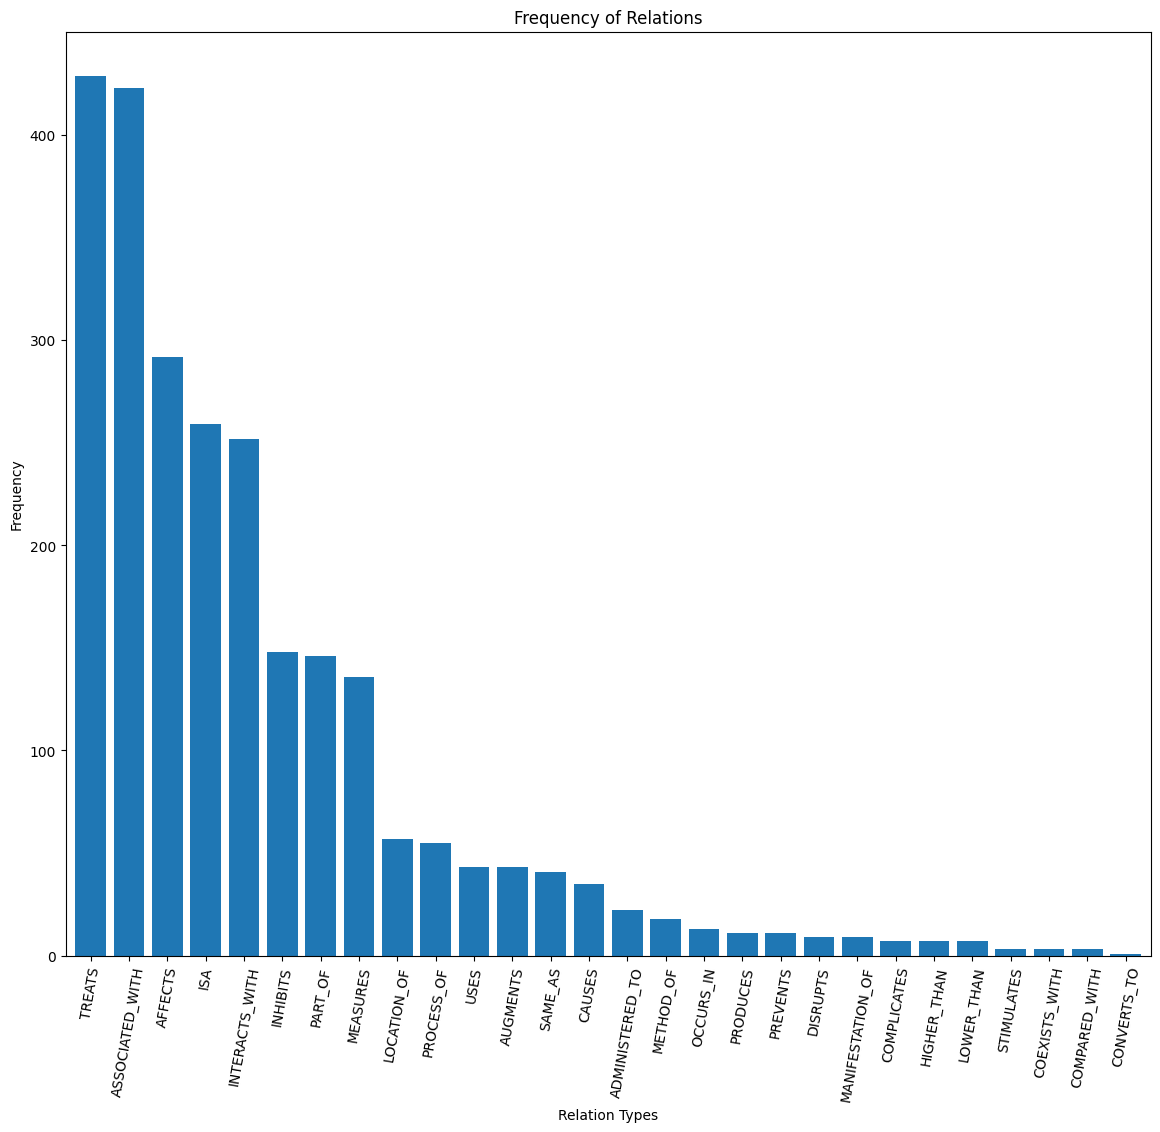

In [ ]:
plot_frequency(llama3_70b_triples_canonical_dedup_new_df, 'relation', 'Relation Types', 'Frequency', 'Frequency of Relations')

## 7. Knowledge Graph

In [ ]:
def create_pyvis_graph(triples_df, output_file):
    # Initialise a pyvis network object
    net = Network(notebook=True,
                  cdn_resources="in_line",
                  directed=True,
                  select_menu=True,
                  filter_menu=True)

    # Add nodes and edges to the network
    for index, row in triples_df.iterrows():
        head = row['head_entity']
        tail = row['tail_entity']
        relation = row['relation']

        # Add nodes
        net.add_node(head, title=head, label=head)
        net.add_node(tail, title=tail, label=tail)

        # Add edge with the relation as the title
        net.add_edge(head, tail, title=relation, label=relation)

    # Print the number of nodes and edges
    print(f"Graph with {len(net.nodes)} nodes and {len(net.edges)} edges.")

    # Generate the graph and save to HTML file
    net.save_graph(output_file)

    # Display the graph
    display(HTML(output_file))

In [ ]:
create_pyvis_graph(llama3_70b_triples_canonical_dedup_new_df, 'groq_llama3-70b_graph.html')

Graph with 1434 nodes and 2483 edges.


### References

* https://towardsdatascience.com/relation-extraction-with-llama3-models-f8bc41858b9e

* https://github.com/tomasonjo/blogs/blob/master/llm/kg_construction_llama3groq.ipynb

* https://www.youtube.com/watch?v=ky8LQE-82xs

* https://github.com/projectwilsen/KnowledgeGraphLLM/blob/main/tutorial/2_convert_any_text_into_a_kg/notebook.ipynb


* Berger, W., Fooladi, A., Lindgren, M., Messo, M., Rosengren, J., & Rådmann, L. (2023). Exploring Data Extraction and Relation Identification Using Machine Learning: Utilizing Machine-Learning Techniques to Extract Relevant Information from Climate Reports (Dissertation). [Full text](https://uu.diva-portal.org/smash/get/diva2:1763051/FULLTEXT01.pdf)\
Retrieved from https://urn.kb.se/resolve?urn=urn:nbn:se:uu:diva-503564


* https://groq.com/


* https://console.groq.com/playground


* Kilicoglu, H. et al. (2011). Constructing a semantic predication gold standard from the biomedical literature. *BMC Bioinformatics*, *12*:486 (2011). [doi:10.1186/1471-2105-12-486](https://doi.org/10.1186/1471-2105-12-486)


* Kilicoglu, H. et al. (2020). Broad-coverage biomedical relation extraction with SemRep. *BMC Bioinformatics*, *21*:188 (2020). [doi:10.1186/s12859-020-3517-7](https://doi.org/10.1186/s12859-020-3517-7)

* [SemRep ontology and indicator rules](https://semrep.nlm.nih.gov/GoldStandard.html)

